# This code was inspired by https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

# Import necessary Libraries

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "true"

from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


import nltk

In [122]:
# Read in data
df = pd.read_csv('nykaa_labeled.csv')
# print(df.shape)
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality


# Star Rating count

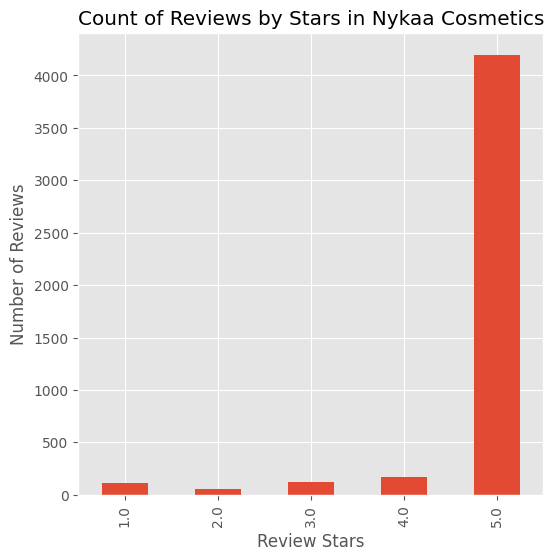

In [123]:
ax = df['review_rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars in Nykaa Cosmetics',
          figsize=(6, 6))
ax.set_xlabel('Review Stars')
ax.set_ylabel('Number of Reviews')
plt.show()

In [87]:
example = df['review_text'][50]
print(example)

Moisture my lips whole day and not so oily looking..gives natural pink lips love ittt


# Vader Sentiment Analysis

In [88]:
sia = SentimentIntensityAnalyzer()

In [89]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.7884}

In [124]:
# Apply VADER sentiment analysis
df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = df['review_text'].apply(lambda text: pd.Series(sia.polarity_scores(text)))

In [125]:
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label,vader_neg,vader_neu,vader_pos,vader_compound
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade,0.000,0.345,0.655,0.8225
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.725,0.275,0.3919
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.075,0.650,0.275,0.7949
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,1.000,0.000,0.0000
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.513,0.487,0.8588


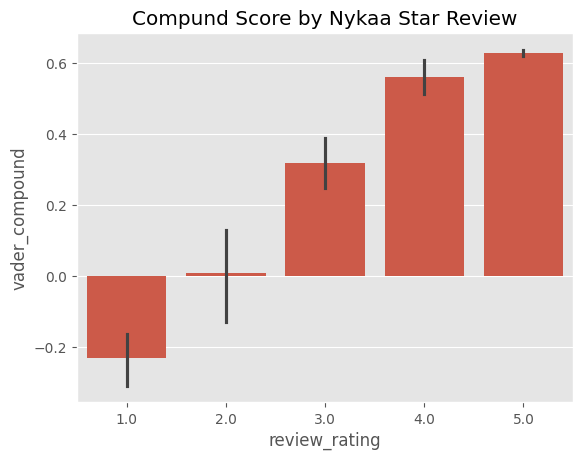

In [126]:
ax = sns.barplot(data=df, x='review_rating', y='vader_compound')
ax.set_title('Compund Score by Nykaa Star Review')
plt.show()

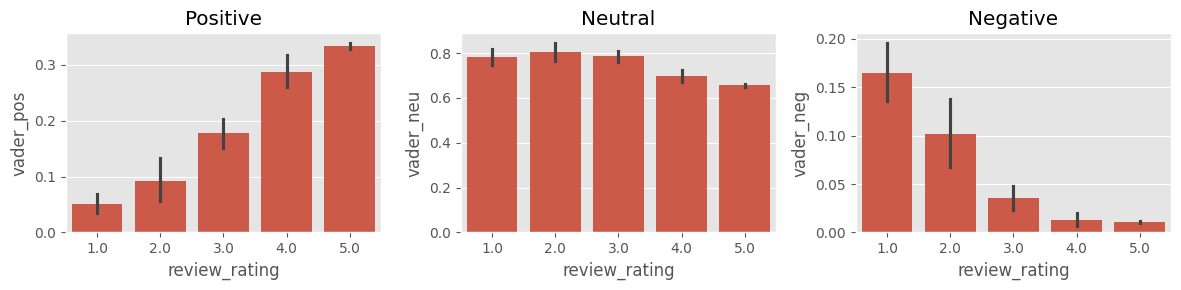

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='review_rating', y='vader_pos', ax=axs[0])
sns.barplot(data=df, x='review_rating', y='vader_neu', ax=axs[1])
sns.barplot(data=df, x='review_rating', y='vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# RoBERTa Sentiment Analysis

In [128]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [129]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [130]:
# Apply RoBERTa sentiment analysis
df[['roberta_neg', 'roberta_neu', 'roberta_pos']] = df['review_text'].apply(lambda text: pd.Series(polarity_scores_roberta(text)))

In [131]:
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade,0.000,0.345,0.655,0.8225,0.002430,0.013603,0.983967
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.725,0.275,0.3919,0.002012,0.040543,0.957445
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.075,0.650,0.275,0.7949,0.016745,0.071183,0.912072
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,1.000,0.000,0.0000,0.003712,0.137185,0.859103
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.513,0.487,0.8588,0.001412,0.007856,0.990732


In [133]:
def get_sentiment_label(vader_compound, roberta_neg, roberta_neu, roberta_pos):
    # Define thresholds for sentiment labels
    vader_threshold = 0.05
    roberta_threshold = 0.33
    
    # Determine sentiment label based on VADER compound score
    if vader_compound >= vader_threshold:
        vader_label = 'positive'
    elif vader_compound <= -vader_threshold:
        vader_label = 'negative'
    else:
        vader_label = 'neutral'
    
    # Determine sentiment label based on RoBERTa scores
    roberta_scores = {'negative': roberta_neg, 'neutral': roberta_neu, 'positive': roberta_pos}
    max_sentiment = max(roberta_scores, key=roberta_scores.get)
    
    return vader_label, max_sentiment

# Apply the function to create new columns for sentiment labels
df['vader_sentiment'], df['roberta_sentiment'] = zip(*df.apply(
    lambda row: get_sentiment_label(row['vader_compound'], row['roberta_neg'], row['roberta_neu'], row['roberta_pos']),
    axis=1
))

# Display the first few rows of the DataFrame with the new columns
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,vader_sentiment,roberta_sentiment
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade,0.000,0.345,0.655,0.8225,0.002430,0.013603,0.983967,positive,positive
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.725,0.275,0.3919,0.002012,0.040543,0.957445,positive,positive
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.075,0.650,0.275,0.7949,0.016745,0.071183,0.912072,positive,positive
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,1.000,0.000,0.0000,0.003712,0.137185,0.859103,neutral,positive
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.513,0.487,0.8588,0.001412,0.007856,0.990732,positive,positive


# TextBlob Sentiment Analysis

In [135]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create a new column for TextBlob sentiment labels
df['textblob_sentiment'] = df['review_text'].apply(get_textblob_sentiment)

In [136]:
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,vader_sentiment,roberta_sentiment,textblob_sentiment
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade,0.000,0.345,0.655,0.8225,0.002430,0.013603,0.983967,positive,positive,positive
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.725,0.275,0.3919,0.002012,0.040543,0.957445,positive,positive,neutral
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.075,0.650,0.275,0.7949,0.016745,0.071183,0.912072,positive,positive,positive
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,1.000,0.000,0.0000,0.003712,0.137185,0.859103,neutral,positive,positive
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,0.000,0.513,0.487,0.8588,0.001412,0.007856,0.990732,positive,positive,positive


# Drop Numerical Values

In [140]:
columns_to_drop = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg', 'roberta_pos', 'roberta_neu']
df.drop(columns=columns_to_drop, inplace=True)

In [141]:
df.head()

,product_id,review_text,review_date,review_rating,product_title,Dominant_Topic_Label,vader_sentiment,roberta_sentiment,textblob_sentiment
0,950973,I loved it perfect for dusky skin,2021-07-22 15:11:00,5.0,Nykaa Matte to Last! Mini Metallic Liquid Lips...,Shade,positive,positive,positive
1,422905,Blueberry lipbalm has a milk fragrance but wor...,2020-06-06 03:00:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,positive,positive,neutral
2,422905,I liked it. Moisturize lips but i dont like it...,2020-08-10 21:05:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,positive,positive,positive
3,422905,Very light to apply..n very nourishing..,2020-12-02 18:04:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,neutral,positive,positive
4,422905,I love this lip balm.It moisturizes my lips we...,2020-08-07 14:53:00,5.0,Nykaa Serial Kisser Lip Balm - Raspberry,Product Quality,positive,positive,positive


# Aspect-Based Sentiment Analysis

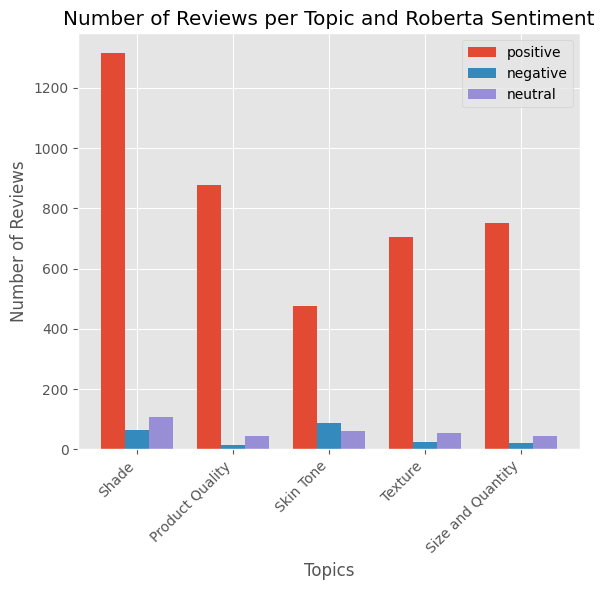

In [137]:
# Group by topic and sentiment type and count the number of reviews
grouped_counts = df.groupby(['Dominant_Topic_Label', 'roberta_sentiment']).size().unstack(fill_value=0)

# Get unique topics
topics = df['Dominant_Topic_Label'].unique()

# Get sentiment types
sentiment_types = ['positive', 'negative', 'neutral']

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
width = 0.25
x = np.arange(len(topics))

for i, sentiment_type in enumerate(sentiment_types):
    counts = grouped_counts[sentiment_type]
    ax.bar(x + (i - 1) * width, counts, width, label=sentiment_type)

ax.set_xlabel('Topics')
ax.set_ylabel('Number of Reviews')
ax.set_title('Number of Reviews per Topic and Roberta Sentiment')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [143]:
# Save the DataFrame to a CSV file
df.to_csv('nykaa_sentiment.csv', index=False)

# Review sentiment percentages

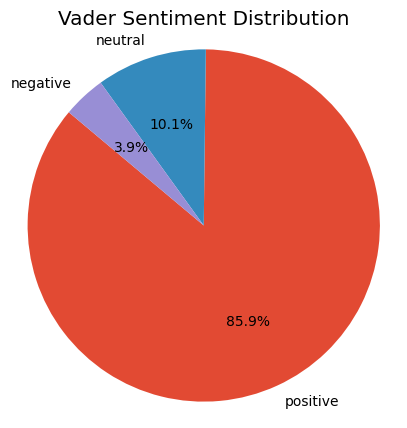

In [164]:
# Group by vader_sentiment and count occurrences
sentiment_counts = df['vader_sentiment'].value_counts()

# Plotting
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Vader Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


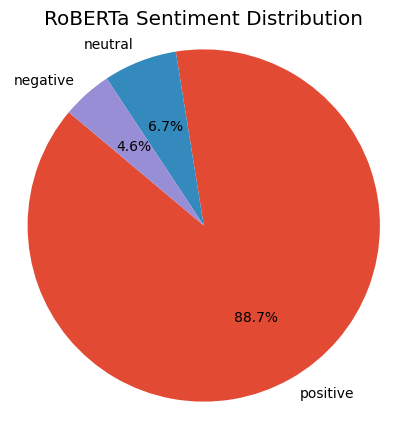

In [163]:
# Group by vader_sentiment and count occurrences
sentiment_counts = df['roberta_sentiment'].value_counts()

# Plotting
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('RoBERTa Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

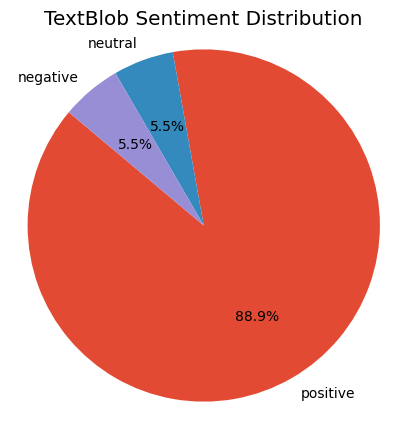

In [165]:
# Group by vader_sentiment and count occurrences
sentiment_counts = df['textblob_sentiment'].value_counts()

# Plotting
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('TextBlob Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Evaluate Sentiment Analysis Methods

In [160]:
# Load the dataset
file_path_labelled = 'nykaa_manually_annotated.csv'
df_labelled = pd.read_csv(file_path_labelled)

# Preprocess the dataset
df_labelled = df_labelled.apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)

# Encode the labels
label_encoder = LabelEncoder()
df_labelled['manual_annotation'] = label_encoder.fit_transform(df_labelled['manual_annotation'])
df_labelled['vader_sentiment'] = label_encoder.transform(df_labelled['vader_sentiment'])
df_labelled['roberta_sentiment'] = label_encoder.transform(df_labelled['roberta_sentiment'])
df_labelled['textblob_sentiment'] = label_encoder.transform(df_labelled['textblob_sentiment'])

# Prepare ground truth and predictions
y_true = df_labelled['manual_annotation']
y_vader = df_labelled['vader_sentiment']
y_roberta = df_labelled['roberta_sentiment']
y_textblob = df_labelled['textblob_sentiment']

# Function to evaluate models
def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {'Confusion Matrix': cm, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Evaluate each model
vader_results = evaluate_model(y_true, y_vader)
roberta_results = evaluate_model(y_true, y_roberta)
textblob_results = evaluate_model(y_true, y_textblob)

# Display results
print("Vader Results:", vader_results)
print("RoBERTa Results:", roberta_results)
print("TextBlob Results:", textblob_results)

Vader Results: {'Confusion Matrix': array([[26, 14, 10],
       [ 4, 10, 36],
       [ 0,  3, 47]], dtype=int64), 'Accuracy': 0.5533333333333333, 'Precision': 0.5808044603743528, 'Recall': 0.5533333333333333, 'F1-Score': 0.5223609723609723}
RoBERTa Results: {'Confusion Matrix': array([[39,  7,  4],
       [ 4, 14, 32],
       [ 0,  1, 49]], dtype=int64), 'Accuracy': 0.68, 'Precision': 0.7066036562616589, 'Recall': 0.68, 'F1-Score': 0.6511748307447232}
TextBlob Results: {'Confusion Matrix': array([[31,  3, 16],
       [ 7,  5, 38],
       [ 0,  2, 48]], dtype=int64), 'Accuracy': 0.56, 'Precision': 0.5954592363261093, 'Recall': 0.56, 'F1-Score': 0.5009303561935141}


In [ ]:
# Vader Results: 
# 'Confusion Matrix': array([[26, 14, 10],
#                            [ 4, 10, 36],
#                            [ 0,  3, 47]],  
# 'Accuracy': 0.5533333333333333, 
# 'Precision': 0.5808044603743528, 
# 'Recall': 0.5533333333333333, 
# 'F1-Score': 0.5223609723609723


# RoBERTa Results: 
# 'Confusion Matrix': array([[39,  7,  4],
#                            [ 4, 14, 32],
#                            [ 0,  1, 49]], 
# 'Accuracy': 0.68, 
# 'Precision': 0.7066036562616589, 
# 'Recall': 0.68, 
# 'F1-Score': 0.6511748307447232

# TextBlob Results: {'Confusion Matrix': array([[31,  3, 16],
#                                               [ 7,  5, 38],
#                                               [ 0,  2, 48]], 
# 'Accuracy': 0.56, 
# 'Precision': 0.5954592363261093, 
# 'Recall': 0.56, 
# 'F1-Score': 0.5009303561935141